In [14]:
__author__ = "Yun-Su Kim, Author1"
__copyright__ = "Copyright 2022, Gwangju Institute of Science and Technology"
__credits__ = ["Yun-Su Kim", "Author1"]
__version__ = "1.0"
__maintainer__ = "Yun-Su Kim"
__email__ = "yunsukim@gist.ac.kr"
__status__ = "Test"

import numpy as np
import matplotlib.pyplot as plt
from docplex.mp.model import Model

### 발전기 객체 모델 / 단위: Power in MW, Ramp in MW/min
class ThermalGenerator:
    def __init__(self, name, busNumber, minMaxPower, rampUpDownLimit, costCoeff, numberOfPieces):
        self.name = name
        self.busNumber = busNumber
        self.minPower = minMaxPower[0]
        self.maxPower = minMaxPower[1]
        self.rampUpLimit = rampUpDownLimit[0]
        self.rampDownLimit = rampUpDownLimit[1]
        self.a = costCoeff[0]
        self.startupCost = costCoeff[3]
        self.shutdownCost = costCoeff[4]
        
        slopesOfCostFunction = np.zeros(numberOfPieces)
        maxPowerPerPiece = self.maxPower / numberOfPieces
        self.maxPowerPerPiece = maxPowerPerPiece
        for i in range(numberOfPieces):
            slopesOfCostFunction[i] = ( costCoeff[0] + costCoeff[1]*(maxPowerPerPiece*(i + 1)) 
                                       + costCoeff[2]*(maxPowerPerPiece*(i + 1))**2
                                       - costCoeff[0] - costCoeff[1]*maxPowerPerPiece*i
                                       - costCoeff[2]*(maxPowerPerPiece*i)**2 ) / maxPowerPerPiece
        self.slopes = slopesOfCostFunction

class PumpedStorage:
    def __init__(self, name, busNumber, minMaxPowerPump, rampUpDownLimit, initTermSOC, maxCapacity, efficiency, isFixedSpeed, fixedPumpPower):
        self.name = name
        self.busNumber = busNumber
        self.minPower = minMaxPowerPump[0]
        self.maxPower = minMaxPowerPump[1]
        self.minPump = minMaxPowerPump[2]
        self.maxPump = minMaxPowerPump[3]
        self.rampUpLimit = rampUpDownLimit[0]
        self.rampDownLimit = rampUpDownLimit[1]
        self.initSOC = initTermSOC[0]
        self.termSOC = initTermSOC[1]
        self.maxCapacity = maxCapacity
        self.efficiency = efficiency
        self.isFixedSpeed = isFixedSpeed
        self.fixedPumpPower = fixedPumpPower
        
class EnergyStorage:
    def __init__(self, name, busNumber, minMaxPower, initTermSOC, maxCapacity, efficiency):
        self.name = name
        self.busNumber = busNumber
        self.minPower = minMaxPower[0]
        self.maxPower = minMaxPower[1]
        self.initSOC = initTermSOC[0]
        self.termSOC = initTermSOC[1]
        self.maxCapacity = maxCapacity
        self.efficiency = efficiency

### 함수 목록
def calculateGenCost(slopes, powers, isOn, a):
    nSlope = len(slopes)
    cost = 0
    for i in range(nSlope):
        cost = cost + slopes[i]*powers[i]
    cost = cost + isOn*a
    return cost

def runDcPowerFlow(bus, branch):
    nBus = np.shape(bus)[0]
    nBranch = np.shape(branch)[0]
    B = np.zeros((nBus,nBus))
    
    for i in range(nBranch):
        x = branch[i,0,None]    #Get 'from bus'
        y = branch[i,1,None]    #Get 'to bus'
        B[int(x-1),int(y-1)] = branch[i,2,None] #Set Suceptance on B matrix
        B[int(y-1),int(x-1)] = branch[i,2,None] #Set Suceptance on B matrix
        B[int(x-1),int(x-1)] = (B[int(x-1),int(x-1)] - branch[i,2,None])
        B[int(y-1),int(y-1)] = (B[int(y-1),int(y-1)] - branch[i,2,None])
    B = np.delete(B,0,0)    #Delete swing bus data
    B = np.delete(B,0,1)    #Delete swing bus data
    B = np.asmatrix(B)      #Convert to matrix
    B = np.linalg.inv(B)    #Invert Y-bus matrix

    busNetPower = bus[1:,1,None] - bus[1:,2,None] #Solve for net power at each bus except swing bus
    busNetPower = np.asmatrix(busNetPower)       #Convert to matrix

    theta = B*busNetPower           #swing bus를 제외한 theta 계산
    theta = np.vstack((0,theta))    #swing bus theta=0 row1에 추가

    output = branch.astype(float)   #Copy branch array over to an output array

    for i in range(nBranch):
        x = branch[i,0,None]    #Get 'from bus'
        y = branch[i,1,None]    #Get 'to bus'
        output[i,2,None] = -branch[i,2,None]*(theta[int(x-1)]-theta[int(y-1)])
      
    return [nBus, nBranch, B, output]


In [15]:
bus

array([[1., 0., 0.],
       [2., 0., 0.],
       [3., 0., 0.],
       [4., 0., 0.]])

In [16]:
branch

array([[  1.,   2., -10.],
       [  1.,   3., -10.],
       [  1.,   4., -10.],
       [  2.,   3., -10.],
       [  3.,   4., -10.]])

In [22]:
a,b,c,d = runDcPowerFlow(bus,branch)

In [17]:
print(a)
print(b,'\n',c,'\n\n',d)

4
5 
 [[0.0625 0.025  0.0125]
 [0.025  0.05   0.025 ]
 [0.0125 0.025  0.0625]] 

 [[1. 2. 0.]
 [1. 3. 0.]
 [1. 4. 0.]
 [2. 3. 0.]
 [3. 4. 0.]]


In [18]:
### Load data
load = [3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 4, 4, 5, 6, 6, 6, 5, 4, 4, 5, 6, 4, 2, 0]
UNIT_TIME = 1 # Timeslot마다 에너지MWh를 구하기 위해 출력MW에 곱해져야하는 시간 단위, 1/4 = 15 min
SOC_PUMP_MIN = 0.4
SOC_PUMP_MAX = 1
SOC_PUMP_INIT = 0.9
SOC_PUMP_TERM = 0.8
SOC_ESS_MIN = 0.3
SOC_ESS_MAX = 0.8
SOC_ESS_INIT = 0.5
SOC_ESS_TERM = 0.5
N_PIECE = 3 # cost function을 선형화할 구간 수
costCoeff = [1, 2, 3, 2, 1] # a, b, c 계수, startup, shutdown 비용
# 조류계산 고려시
bus = np.loadtxt('bus.txt', delimiter = ',', skiprows = 1, dtype = float)
branch = np.loadtxt('branch.txt', delimiter = ',', skiprows = 1, dtype = float)
[nBus, nBranch, B, powerFlowResult] = runDcPowerFlow(bus, branch)
FLOW_LIMIT = 2*np.ones(nBranch)    #Branch별 flow limit. 임의설정

### 발전기 목록 생성 및 추가
generatorList = []
pumpList = []
essList = []
#***중요 : 발전기 종류별로 최소 하나는 추가해야 함. 실제로 발전기가 없는 경우는 최소최대 발전을 0으로 설정 
generatorList.append( ThermalGenerator('신고리', 2, [2, 10], [1/60, 1/60], costCoeff, N_PIECE) )
pumpList.append( PumpedStorage('청평', 3, [1, 10, 0, 10], [5/60, 5/60], [SOC_PUMP_INIT, SOC_PUMP_TERM], 20, 0.8, 1, 1) )
essList.append( EnergyStorage('한전1', 4, [0, 1], [SOC_ESS_INIT, SOC_ESS_TERM], 5, 0.9) )

### Set number of variables
nGen = len(generatorList)
nPump = len(pumpList)
nEss = len(essList)
nTimeslot = len(load)

In [19]:
generatorList[0].name

'신고리'

In [20]:
##### MILP #####
# 최적화 변수들에는 기존에 정한 naming rule을 따르지 않고 보편적으로 사용되는 변수 알파벳을 사용
# 변수 알파벳 옆의 아래 첨자는 '_'를 이용해 표시했고 아래 첨자는 가능한 naming rule을 따름

m = Model(name='Unit Commitment')

### 변수 생성
P_gen = m.continuous_var_list(nGen)
for i in range(nGen):
    P_gen[i] = m.continuous_var_matrix(N_PIECE, nTimeslot, lb=0, ub=generatorList[i].maxPowerPerPiece)
U_gen = m.binary_var_matrix(nGen, nTimeslot)
SU_gen = m.binary_var_matrix(nGen, nTimeslot)
SD_gen = m.binary_var_matrix(nGen, nTimeslot)

for i in range(nPump):
    P_pumpChg = m.continuous_var_matrix(nPump, nTimeslot, lb=0, ub=pumpList[i].maxPower)
    P_pumpDis = m.continuous_var_matrix(nPump, nTimeslot, lb=0, ub=pumpList[i].maxPump)
U_pumpChg = m.binary_var_matrix(nPump, nTimeslot)
U_pumpDis = m.binary_var_matrix(nPump, nTimeslot)

for i in range(nEss):
    P_essChg = m.continuous_var_matrix(nEss, nTimeslot, lb=0, ub=essList[i].maxPower)
    P_essDis = m.continuous_var_matrix(nEss, nTimeslot, lb=0, ub=essList[i].maxPower)
U_essChg = m.binary_var_matrix(nEss, nTimeslot)
U_essDis = m.binary_var_matrix(nEss, nTimeslot)

### 제약조건
# 모든전원 최소 최대 출력 제약, ONOFF 제약, 수급균형 제약
for j in range(nTimeslot):
    for i in range(nGen):
        m.add_constraint( sum(P_gen[i][k, j] for k in range(N_PIECE)) >= U_gen[i, j]*generatorList[i].minPower )
        m.add_constraint( sum(P_gen[i][k, j] for k in range(N_PIECE)) <= U_gen[i, j]*generatorList[i].maxPower )
        m.add_constraint( SU_gen[i, j] + SD_gen[i, j] <= 1 )
        m.add_constraint( sum(P_gen[i][k, j] for k in range(N_PIECE))
                          + sum(P_pumpDis[l, j] for l in range(nPump))
                          - sum(P_pumpChg[l, j] for l in range(nPump))
                          + sum(P_essDis[l, j] for l in range(nEss))
                          - sum(P_essChg[l, j] for l in range(nEss)) == load[j] )
    for i in range(nPump):
        m.add_constraint( P_pumpDis[i, j] <= U_pumpDis[i, j]*pumpList[i].maxPower )
        m.add_constraint( P_pumpDis[i, j] >= U_pumpDis[i, j]*pumpList[i].minPower )
        m.add_constraint( P_pumpChg[i, j] 
                         <= U_pumpChg[i, j]*
                         (pumpList[i].maxPump - 0.9999*pumpList[i].isFixedSpeed*(pumpList[i].maxPump - pumpList[i].fixedPumpPower)) )
        m.add_constraint( P_pumpChg[i, j] 
                         >= U_pumpChg[i, j]*
                         (pumpList[i].minPump + 0.9999*pumpList[i].isFixedSpeed*(pumpList[i].fixedPumpPower - pumpList[i].minPump)) )
        m.add_constraint( U_pumpDis[i, j] + U_pumpChg[i, j] <= 1 )
    for i in range(nEss):
        m.add_constraint( P_essDis[i, j] <= U_essDis[i, j]*essList[i].maxPower )
        m.add_constraint( P_essChg[i, j] <= U_essChg[i, j]*essList[i].maxPower )
        m.add_constraint( U_essDis[i, j] + U_essChg[i, j] <= 1 )
# SOC 제약
for j in range(nTimeslot):
    for i in range(nPump):
        m.add_constraint( pumpList[i].initSOC
                          - sum(P_pumpDis[i, k]*UNIT_TIME/pumpList[i].maxCapacity #양수는 발전시 효율 곱하지 않음
                                for k in range(j + 1))
                          + sum(P_pumpChg[i, k]*UNIT_TIME*pumpList[i].efficiency/pumpList[i].maxCapacity
                                for k in range(j + 1)) <=  SOC_PUMP_MAX )
        m.add_constraint( pumpList[i].initSOC
                          - sum(P_pumpDis[i, k]*UNIT_TIME/pumpList[i].maxCapacity
                                for k in range(j + 1))
                          + sum(P_pumpChg[i, k]*UNIT_TIME*pumpList[i].efficiency/pumpList[i].maxCapacity
                                for k in range(j + 1)) >=  SOC_PUMP_MIN )
    for i in range(nEss):
        m.add_constraint( essList[i].initSOC
                          - sum(P_essDis[i, k]*UNIT_TIME/essList[i].efficiency/essList[i].maxCapacity
                                for k in range(j + 1))
                          + sum(P_essChg[i, k]*UNIT_TIME*essList[i].efficiency/essList[i].maxCapacity
                                for k in range(j + 1)) <=  SOC_ESS_MAX )
        m.add_constraint( essList[i].initSOC
                          - sum(P_essDis[i, k]*UNIT_TIME/essList[i].efficiency/essList[i].maxCapacity
                                for k in range(j + 1))
                          + sum(P_essChg[i, k]*UNIT_TIME*essList[i].efficiency/essList[i].maxCapacity
                                for k in range(j + 1)) >=  SOC_ESS_MIN )
for i in range(nPump):
    m.add_constraint( pumpList[i].initSOC
                     - sum(P_pumpDis[i, k]*UNIT_TIME/pumpList[i].maxCapacity for k in range(nTimeslot))
                     + sum(P_pumpChg[i, k]*UNIT_TIME*pumpList[i].efficiency/pumpList[i].maxCapacity for k in range(nTimeslot))
                     >=  pumpList[i].termSOC )
for i in range(nEss):
    m.add_constraint( essList[i].initSOC
                     - sum(P_essDis[i, k]*UNIT_TIME/essList[i].efficiency/essList[i].maxCapacity for k in range(nTimeslot))
                     + sum(P_essChg[i, k]*UNIT_TIME*essList[i].efficiency/essList[i].maxCapacity for k in range(nTimeslot))
                     ==  essList[i].termSOC )
# 전원 rampup down 제약, ONOFF 제약
for j in range(nTimeslot - 1):
    # 발전기 rampup down 제약, ONOFF 제약
    for i in range(nGen):
        m.add_constraint( sum(P_gen[i][k, j + 1] for k in range(N_PIECE))
                         - sum(P_gen[i][k, j] for k in range(N_PIECE)) <= generatorList[i].rampUpLimit*60*UNIT_TIME )
        m.add_constraint( sum(P_gen[i][k, j + 1] for k in range(N_PIECE))
                         - sum(P_gen[i][k, j] for k in range(N_PIECE)) >= -generatorList[i].rampUpLimit*60*UNIT_TIME )
        m.add_constraint( U_gen[i, j + 1] - U_gen[i, j] == SU_gen[i, j + 1] - SD_gen[i, j + 1]  )
    # 양수 rampup down 제약
    for i in range(nPump):
        m.add_constraint( P_pumpDis[i, j + 1] - P_pumpDis[i, j] <= pumpList[i].rampUpLimit*60*UNIT_TIME )
        m.add_constraint( P_pumpDis[i, j + 1] - P_pumpDis[i, j] >= -pumpList[i].rampDownLimit*60*UNIT_TIME )
        #m.add_constraint( P_pumpChg[i, j + 1] - P_pumpChg[i, j] <= pumpList[i].rampUpLimit*60*UNIT_TIME )
        #m.add_constraint( P_pumpChg[i, j + 1] - P_pumpChg[i, j] >= -pumpList[i]rampDownLimit*60*UNIT_TIME )
for i in range(nGen):
    m.add_constraint( U_gen[i, 0] == SU_gen[i, 0] ) # 시작할때부터 발전기 켜져있으면 startup 비용 추가

### ***** 조류계산 제약. DC power line flow 제약만 *****
# '조류계산으로 flow limit violation 확인' 섹션 수행 후 violation 발생한 경우만 포함
# violationList에서 위배 발생한 시간과 branch 검색 가능
#******************중요*************************
#violationList = []  # 첫 번째 수행시만 주석 해제, violation 생기고 나면 주석 처리

nViolatedTimeslot = len(violationList)
busNetPower_var = []
theta_var = []
for i in range(nViolatedTimeslot):
    t = int(violationList[i][0]) # 위배가 발생한 시간 index
    busNetPower_var.append( [0]*(nBus - 1) )
    theta_var.append( [0]*(nBus - 1) )
    
    # 전원들의 발전량을 위치한 모선에 할당
    #busNetPower_var = [0]*(nBus - 1)
    for k in range(nBus - 1):
        for l in range(nGen):
            if generatorList[l].busNumber == k+2: # slack 모선을 제외했으므로 index 2가 0번째 row가 됨
                busNetPower_var[i][k] = busNetPower_var[i][k] + sum(P_gen[l][m, t] for m in range(N_PIECE))
        for l in range(nPump):
            if pumpList[l].busNumber == k+2:
                busNetPower_var[i][k] = busNetPower_var[i][k] + P_pumpDis[l, t] - P_pumpChg[l, t]
        for l in range(nEss):
            if essList[l].busNumber == k+2:
                busNetPower_var[i][k] = busNetPower_var[i][k] + P_essDis[l, t] - P_essChg[l, t]
                
    # 총부하량을 모선별 분배 할당 *** 향후 개선 필요
    busNetPower_var[i][0] = busNetPower_var[i][0] - load[int(t)]*0.3
    busNetPower_var[i][1] = busNetPower_var[i][1] - load[int(t)]*0.3
    busNetPower_var[i][2] = busNetPower_var[i][2] - load[int(t)]*0.4
    busNetPower_var[i] = np.resize(busNetPower_var[i],(nBus - 1,1))
    
    theta_var[i] = np.concatenate((np.zeros([1,1]),B*busNetPower_var[i]), axis=0)
    
    nViolatedBranch = len(violationList[i]) - 1 # list에서 time index는 제외하므로 -1
    for j in range(nViolatedBranch):
        k = int(violationList[i][j + 1]) # 위배한 branch index
        m.add_constraint( -branch[k,2,None][0]*(theta_var[i][int(branch[k,0,None]-1),0]
                                                - theta_var[i][int(branch[k,1,None]-1),0]) <= FLOW_LIMIT[k] )
        m.add_constraint( -branch[k,2,None][0]*(theta_var[i][int(branch[k,0,None]-1),0]
                                                - theta_var[i][int(branch[k,1,None]-1),0]) >= -FLOW_LIMIT[k] )

### 목적함수
m.set_objective("min", sum(generatorList[i].slopes[j]*P_gen[i][j, k] for i in range(nGen) for j in range(N_PIECE)
                           for k in range(nTimeslot))*UNIT_TIME
                + sum(U_gen[i, j]*generatorList[i].a*UNIT_TIME + SU_gen[i, j]*generatorList[i].startupCost
                      + SD_gen[i, j]*generatorList[i].shutdownCost for i in range(nGen) for j in range(nTimeslot)) )
                               
m.print_information()
sol = m.solve()
print(m.objective_value)

### Solution 저장
P_genSol = np.zeros([nGen, nTimeslot])
U_genSol = np.zeros([nGen, nTimeslot])
SU_genSol = np.zeros([nGen, nTimeslot])
SD_genSol = np.zeros([nGen, nTimeslot])
P_pumpDisSol = np.zeros([nPump, nTimeslot])
P_pumpChgSol = np.zeros([nPump, nTimeslot])
U_pumpDisSol = np.zeros([nPump, nTimeslot])
U_pumpChgSol = np.zeros([nPump, nTimeslot])
P_essDisSol = np.zeros([nEss, nTimeslot])
P_essChgSol = np.zeros([nEss, nTimeslot])
U_essDisSol = np.zeros([nEss, nTimeslot])
U_essChgSol = np.zeros([nEss, nTimeslot])
socPump = np.zeros([nPump, nTimeslot])
socEss = np.zeros([nEss, nTimeslot])
for i in range(nTimeslot):
    for j in range(nGen):
        P_genSol[j, i] = sum( sol.get_value(P_gen[j][k, i]) for k in range(N_PIECE) )
        U_genSol[j, i] = sol.get_value(U_gen[j, i])
        SU_genSol[j, i] = sol.get_value(SU_gen[j, i])
        SD_genSol[j, i] = sol.get_value(SD_gen[j, i])
    for j in range(nPump):
        P_pumpDisSol[j, i] = sol.get_value(P_pumpDis[j, i])
        P_pumpChgSol[j, i] = sol.get_value(P_pumpChg[j, i])
        U_pumpDisSol[j, i] = sol.get_value(U_pumpDis[j, i])
        U_pumpChgSol[j, i] = sol.get_value(U_pumpChg[j, i])
        socPump[j, i] = (pumpList[j].initSOC 
                         - sum(P_pumpDisSol[j, k]*UNIT_TIME/pumpList[j].efficiency/pumpList[j].maxCapacity for k in range(i + 1)) 
                         + sum(P_pumpChgSol[j, k]*UNIT_TIME*pumpList[j].efficiency/pumpList[j].maxCapacity for k in range(i + 1)))
    for j in range(nEss):
        P_essDisSol[j, i] = sol.get_value(P_essDis[j, i])
        P_essChgSol[j, i] = sol.get_value(P_essChg[j, i])
        U_essDisSol[j, i] = sol.get_value(U_essDis[j, i])
        U_essChgSol[j, i] = sol.get_value(U_essChg[j, i])
        socEss[j, i] = (essList[j].initSOC 
                        - sum(P_essDisSol[j, k]*UNIT_TIME/essList[j].efficiency/essList[j].maxCapacity for k in range(i + 1)) 
                        + sum(P_essChgSol[j, k]*UNIT_TIME*essList[j].efficiency/essList[j].maxCapacity for k in range(i + 1)))

NameError: name 'violationList' is not defined

In [ ]:
for i in range(nGen):
    plt.plot(P_genSol[i, :], label='P_gen'+str(i))
for i in range(nPump):
    plt.plot(P_pumpDisSol[i, :], label='P_pumpDis'+str(i))
for i in range(nPump):
    plt.plot(-P_pumpChgSol[i, :], label='P_pumpChg'+str(i))
for i in range(nEss):
    plt.plot(P_essDisSol[i, :], label='P_essDis'+str(i))
for i in range(nEss):
    plt.plot(-P_essChgSol[i, :], label='P_essChg'+str(i))
plt.legend()

print(P_genSol[0, :]+P_pumpDisSol[0, :]-P_pumpChgSol[0,:]+P_essDisSol[0, :]-P_essChgSol[0,:])
print(load)
print(sol.get_value(P_gen[0][0, 0]))

NameError: name 'P_genSol' is not defined

In [ ]:
plt.plot(socPump[0,:])
plt.plot(socEss[0,:])

NameError: name 'socPump' is not defined

NameError: name 'U_genSol' is not defined

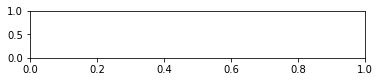

In [ ]:
plt.subplot(411)
plt.plot(U_genSol[0,:], label='gen')
plt.legend()
plt.subplot(412)
plt.plot(SU_genSol[0,:], label='SU')
plt.plot(SD_genSol[0,:], label='SD')
plt.legend()
plt.subplot(413)
plt.plot(U_pumpDisSol[0,:], label='pumpDis')
plt.plot(U_pumpChgSol[0,:], label='pumpChg')
plt.legend()
plt.subplot(414)
plt.plot(U_essDisSol[0,:], label='essDis')
plt.plot(U_essChgSol[0,:], label='essChg')
plt.legend()

In [9]:
### 조류계산으로 flow limit violation 확인
branch = np.loadtxt('branch.txt', delimiter = ',', skiprows = 1, dtype = float)

for i in range(nTimeslot):
    bus = np.loadtxt('bus.txt', delimiter = ',', skiprows = 1, dtype = float)
    
    for k in range(nBus - 1):
        for l in range(nGen):
            if generatorList[l].busNumber == k+2: # slack 모선을 제외했으므로 index 2가 0번째 row가 됨
                bus[k+1,1,None] = bus[k+1,1,None] + P_genSol[l, i]
        for l in range(nPump):
            if pumpList[l].busNumber == k+2:
                bus[k+1,1,None] = bus[k+1,1,None] + P_pumpDisSol[l, i] - P_pumpChgSol[l, i]
        for l in range(nEss):
            if essList[l].busNumber == k+2:
                bus[k+1,1,None] = bus[k+1,1,None] + P_essDisSol[l, i] - P_essChgSol[l, i]

    # 총부하량을 모선별 분배 할당 *** 향후 개선 필요
    bus[1,2,None] = bus[1,2,None] + load[i]*0.3
    bus[2,2,None] = bus[2,2,None] + load[i]*0.3
    bus[3,2,None] = bus[3,2,None] + load[i]*0.4

    powerFlowResult = runDcPowerFlow(bus, branch)[3]
    ## 제약위배가 발생하는 시간대, 발생한 branch만 표시
    if len(powerFlowResult[abs(powerFlowResult[:, 2]) > FLOW_LIMIT]) != 0:
        print('\nLine flow violation in time '+str(i)+':')
        print(powerFlowResult[abs(powerFlowResult[:, 2]) > FLOW_LIMIT])
        nViolatedBranch = np.shape(powerFlowResult[abs(powerFlowResult[:, 2]) > FLOW_LIMIT])[0]
        violatedBranch = np.zeros(nViolatedBranch)
        for j in range(nViolatedBranch):
            violatedBranch[j] = np.where(abs(powerFlowResult[:, 2]) > FLOW_LIMIT)[0][j]
        violationList.append( np.concatenate((i*np.ones(1), violatedBranch)) )


KeyboardInterrupt



In [ ]:
print(violationList)

NameError: name 'violationList' is not defined

In [1]:
a = 10
for i in range(10):
    a += 1

In [ ]:
b = 20
for i in range(100):
    b += 1